### 05_imgstyle_trainsfer
from glob import glob

In [17]:
from glob import glob
from PIL import Image
import numpy as np

dataset_name = "apple2orange"
data_type = "train" 
img_res = (128,128)
path_A = glob("./train_data/%s/%sA/*" % (dataset_name, data_type))
path_B = glob("./train_data/%s/%sB/*" % (dataset_name, data_type))
imgs_A = []
imgs_B = []
for img in path_A:
    img_A = np.asarray(Image.open(img).resize(img_res), dtype=np.uint8)
    imgs_A.append(img_A)
for img in path_B:
    img_B = np.asarray(Image.open(img).resize(img_res), dtype=np.uint8)
    imgs_B.append(img_B)

imgs_A = np.array(imgs_A) / 255.0
imgs_B = np.array(imgs_B) / 255.0

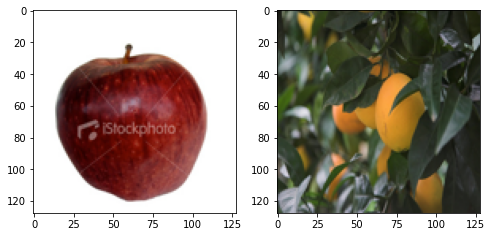

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(imgs_A[131])
plt.subplot(1,2,2)
plt.imshow(imgs_B[131])
plt.show()

In [33]:
from tensorflow import keras
from tensorflow.keras import layers, models

dis_op_dim = 64 ## = gen_op_dim//2
gen_op_dim = 32 ## = dis_op_dim * 2
kernel_size=(4,4)
strides = (2,2)
padding = "same"
img_rows = 128
img_cols = 128
img_channels = 3
img_shape = (img_rows,img_cols,img_channels)

def build_discriminator(named):
    inputs = keras.Input(shape=img_shape, name="inputs_"+named)
    d = layers.Conv2D(filters=dis_op_dim, kernel_size=kernel_size, strides=strides, padding=padding, name="conv_1")(inputs)
    d = layers.LeakyReLU(alpha=0.2, name="relu_1")(d)
    d = layers.Conv2D(filters=dis_op_dim*2, kernel_size=kernel_size, strides=strides, padding=padding, name="conv_2")(d)
    d = layers.LeakyReLU(alpha=0.2, name="relu_2")(d)
    d = layers.LayerNormalization(name="normal_1")(d)
    d = layers.Conv2D(filters=dis_op_dim*4, kernel_size=kernel_size, strides=strides, padding=padding, name="conv_3")(d)
    d = layers.LeakyReLU(alpha=0.2, name="relu_3")(d)
    d = layers.LayerNormalization(name="normal_2")(d)
    d = layers.Conv2D(filters=dis_op_dim*8, kernel_size=kernel_size, strides=strides, padding=padding, name="conv_4")(d)
    d = layers.LeakyReLU(alpha=0.2, name="relu_4")(d)
    d = layers.LayerNormalization(name="normal_3")(d)
    outputs = layers.Conv2D(1, kernel_size=kernel_size, padding=padding, name="valid_"+named)(d)

    return models.Model(inputs, outputs, name="d_model"+named)

d_A = build_discriminator("A")
d_B = build_discriminator("B")
d_A.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
d_B.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
d_A.summary()
#d_B.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_A (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
relu_1 (LeakyReLU)           (None, 64, 64, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 128)       131200    
_________________________________________________________________
relu_2 (LeakyReLU)           (None, 32, 32, 128)       0         
_________________________________________________________________
normal_1 (LayerNormalization (None, 32, 32, 128)       256       
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 256)       524544

In [37]:

def build_generator(named):
    d0 = keras.Input(shape=img_shape, name="g_inputs"+named)
    d1 = layers.Conv2D(filters=gen_op_dim, kernel_size=kernel_size, strides=strides, padding=padding, name="g_conv_1")(d0)
    d1 = layers.LeakyReLU(alpha=0.2, name="g_relu_1")(d1)
    d1 = layers.LayerNormalization(name="g_normal_1")(d1)
    d2 = layers.Conv2D(filters=gen_op_dim*2, kernel_size=kernel_size, strides=strides, padding=padding, name="g_conv_2")(d1)
    d2 = layers.LeakyReLU(alpha=0.2, name="g_relu_2")(d2)
    d2 = layers.LayerNormalization(name="g_normal_2")(d2)
    d3 = layers.Conv2D(filters=gen_op_dim*4, kernel_size=kernel_size, strides=strides, padding=padding, name="g_conv_3")(d2)
    d3 = layers.LeakyReLU(alpha=0.2, name="g_relu_3")(d3)
    d3 = layers.LayerNormalization(name="g_normal_3")(d3)
    d4 = layers.Conv2D(filters=gen_op_dim*8, kernel_size=kernel_size, strides=strides, padding=padding, name="g_conv_4")(d3)
    d4 = layers.LeakyReLU(alpha=0.2, name="g_relu_4")(d4)
    d4 = layers.LayerNormalization(name="g_normal_4")(d4)
    
    u1 = layers.UpSampling2D(size=2, name="up_sammple_1")(d4)
    u1 = layers.Conv2D(filters=gen_op_dim*4, kernel_size=kernel_size, padding=padding, activation='relu', name="g_conv_5")(u1)
    u1 = layers.LayerNormalization(name="g_normal_5")(u1)
    u1 = layers.Concatenate()([u1, d3])
    
    u2 = layers.UpSampling2D(size=2, name="up_sammple_2")(u1)
    u2 = layers.Conv2D(filters=gen_op_dim*2, kernel_size=kernel_size, padding=padding, activation='relu', name="g_conv_6")(u2)
    u2 = layers.LayerNormalization(name="g_normal_6")(u2)
    u2 = layers.Concatenate()([u2, d2])
    
    u3 = layers.UpSampling2D(size=2, name="up_sammple_3")(u2)
    u3 = layers.Conv2D(filters=gen_op_dim, kernel_size=kernel_size, padding=padding, activation='relu', name="g_conv_7")(u3)
    u3 = layers.LayerNormalization(name="g_normal_7")(u3)
    u3 = layers.Concatenate()([u3, d1])
    
    u4 = layers.UpSampling2D(size=2, name="up_sammple_4")(u3)
    output_img = layers.Conv2D(img_shape[2], kernel_size=kernel_size, padding=padding, activation='tanh')(u4)
    
    return models.Model(d0,output_img, name="g_model"+named)    

g_AB = build_generator("AB")
g_BA = build_generator("BA")
g_AB.summary()

Model: "g_modelAB"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_inputsAB (InputLayer)         [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
g_conv_1 (Conv2D)               (None, 64, 64, 32)   1568        g_inputsAB[0][0]                 
__________________________________________________________________________________________________
g_relu_1 (LeakyReLU)            (None, 64, 64, 32)   0           g_conv_1[0][0]                   
__________________________________________________________________________________________________
g_normal_1 (LayerNormalization) (None, 64, 64, 32)   64          g_relu_1[0][0]                   
__________________________________________________________________________________________

In [40]:
img_A = keras.Input(shape=img_shape)
img_B = keras.Input(shape=img_shape)
# 分別使用生成器g_AB和g_BA轉換A、B域的圖形 對輸入層的資料進行風格轉移
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)

#將轉換後的圖形進行逆轉換，還原到原始的域中
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)

# 對圖形資料進行標誌映射
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# 在整合模型中，只需訓練生成器，把待識別的參數設為不更新狀態
d_A.trainable = False
d_B.trainable = False

# 判別器識別生成器產生的圖形真假，判別是否進行風格轉移
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

#初始化損失參數
lambda_cycle = 10.0 #相融合性loss
lambda_id = 0.1 * lambda_cycle #一致性loss
#建構一個生成器訓練模型，兩個生成器模型g_AB和g_BA是共用的，用來訓練生成器以迷惑判別器
combined = keras.Model(inputs=[img_A, img_B],outputs=[ valid_A, valid_B,reconstr_A, reconstr_B,img_A_id, img_B_id ])
#編譯生成器訓練模型，該模型有4個子模型，6個輸出，因此loss_weights有4個，loss函數有6個
combined.compile(optimizer="adam",
                 loss=['mse', 'mse','mae', 'mae','mae', 'mae'],
                 loss_weights=[  1, 1,lambda_cycle, lambda_cycle,lambda_id, lambda_id ])
combined.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
g_modelBA (Model)               (None, 128, 128, 3)  1546819     input_2[0][0]                    
                                                                 g_modelAB[1][0]                  
                                                                 input_1[0][0]                    
____________________________________________________________________________________________

In [56]:
img_rows = 128
img_cols = 128
img_channels = 3
img_shape = (img_rows,img_cols,img_channels)

patch = int(img_rows / 2**4)
#disc_patch = (patch, patch, 1)

num_train = min(len(imgs_A),len(imgs_B))
batch_size = 1
for i in range(num_train):
    img_A = imgs_A[i:i+1]
    img_B = imgs_B[i:i+1]
    valid = np.ones((batch_size,patch,patch,1))
    fake = np.zeros((batch_size,patch,patch,1))
    
    fake_B = g_AB.predict(img_A, batch_size=1) #steps
    fake_A = g_BA.predict(img_B, batch_size=1)
    
    # Train the discriminators (original images = real / translated = Fake)
    dA_loss_real =d_A.train_on_batch(img_A, valid)
    dA_loss_fake = d_A.train_on_batch(fake_A, fake)
    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

    dB_loss_real = d_B.train_on_batch(img_B, valid)
    dB_loss_fake = d_B.train_on_batch(fake_B, fake)
    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

    d_loss = 0.5 * np.add(dA_loss, dB_loss)
    if (i+1) % 100 == 0:
        print("判別器loss:",d_loss)


In [58]:
import os
g_AB_model_file = os.path.join("model_data","g_AB.h5")
g_BA_model_file = os.path.join("model_data","g_BA.h5")
d_A_model_file = os.path.join("model_data","d_A.h5")
d_B_model_file = os.path.join("model_data","d_B.h5")

models.save_model(g_BA, g_BA_model_file,save_format='h5')
models.save_model(g_AB, g_AB_model_file,save_format='h5')
models.save_model(d_A, d_A_model_file,save_format='h5')
models.save_model(d_B, d_B_model_file,save_format='h5')

In [63]:
for i in range(num_train):
    img_A = imgs_A[i:i+1]
    img_B = imgs_B[i:i+1]
    g_loss = combined.train_on_batch([img_A, img_B], [valid, valid, img_A, img_B, img_A, img_B])
    if (i+1) % 100 == 0:
        print("生成器loss:",g_loss)
print("FINISH")
comb_model_file = os.path.join("model_data","comb.h5")
models.save_model(combined, comb_model_file,save_format='h5')

In [75]:
index = 13
test_img = imgs_A[index:index+1]
test_A = g_AB.predict(test_img)
test_B = g_BA.predict(test_A)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


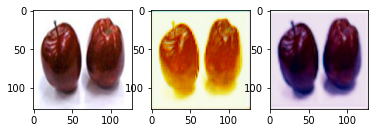

In [76]:
plt.subplot(1,3,1)
plt.imshow(test_img[0])
plt.subplot(1,3,2)
plt.imshow(test_A[0])
plt.subplot(1,3,3)
plt.imshow(test_B[0])
plt.show()